In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm

/Users/malenamalka/opt/anaconda3/lib/python3.9/site-packages/requests/__init__.py:113: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (2.0.3)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn(


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Week 1 work
start_date = '2000-01-01'
end_date = '2009-12-31'
sp500_data = yf.download('^GSPC', start=start_date, end=end_date, interval='1mo')
sp500_data.columns = sp500_data.columns.get_level_values(0)
sp500_data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2000-01-01,1394.459961,1478.000000,1350.140015,1469.250000,21494400000
2000-02-01,1366.420044,1444.550049,1325.069946,1394.459961,20912000000
2000-03-01,1498.579956,1552.869995,1346.619995,1366.420044,26156200000
2000-04-01,1452.430054,1527.189941,1339.400024,1498.579956,20106460000
2000-05-01,1420.599976,1481.510010,1361.089966,1452.430054,19898300000


In [4]:
sp500_data = sp500_data[['Close']].dropna()

sp500_data['Log Return'] = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1))

sp500_data.dropna(inplace=True)

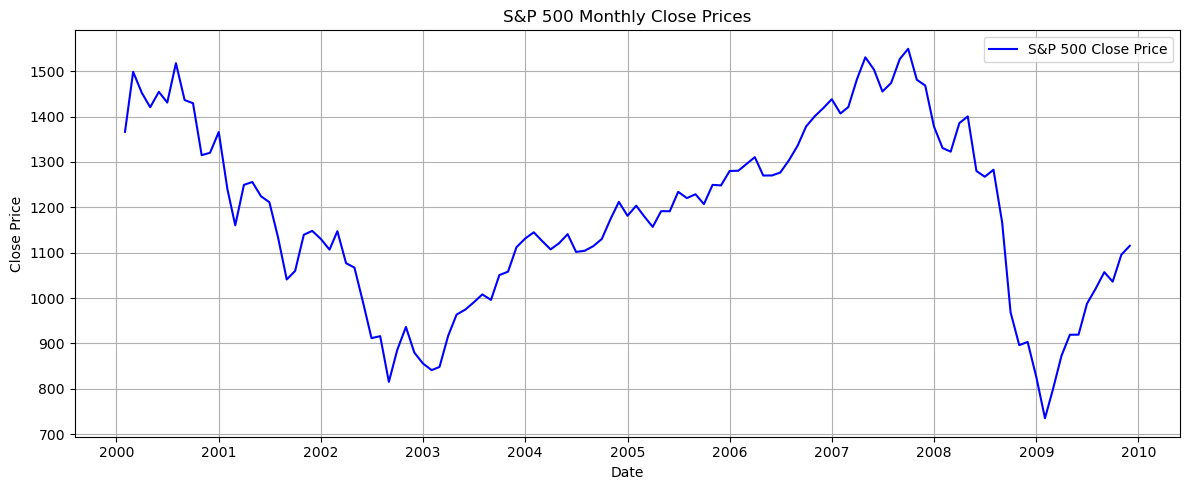

In [5]:
plt.figure(figsize=(12, 5))
plt.plot(sp500_data.index, sp500_data['Close'], label='S&P 500 Close Price', color='blue')
plt.title('S&P 500 Monthly Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

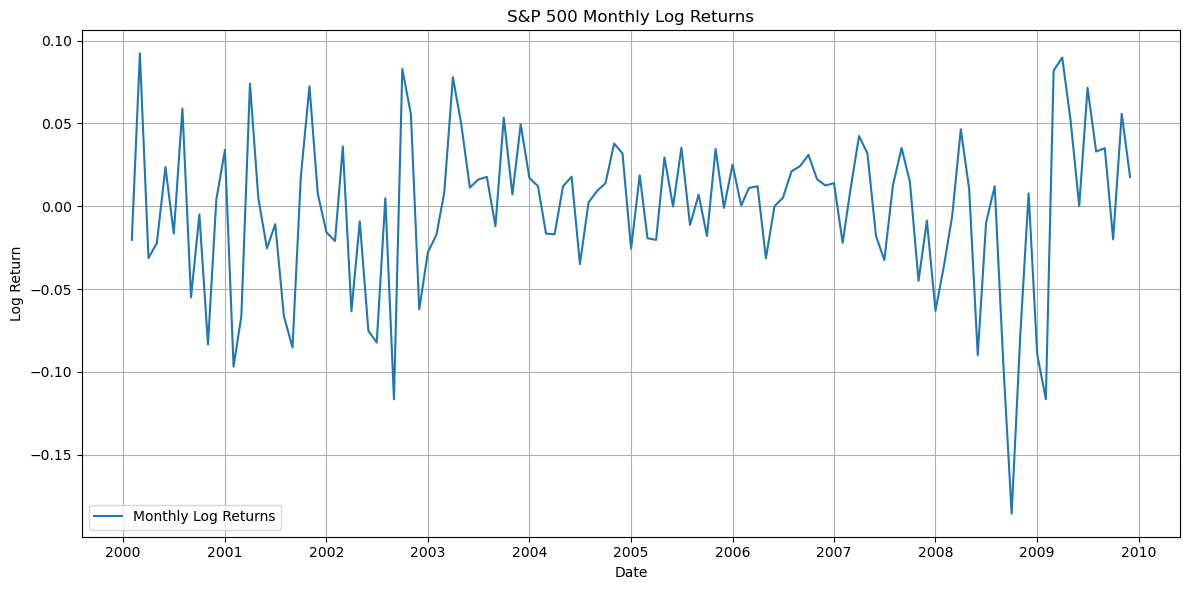

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Monthly Log Returns')
plt.title('S&P 500 Monthly Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

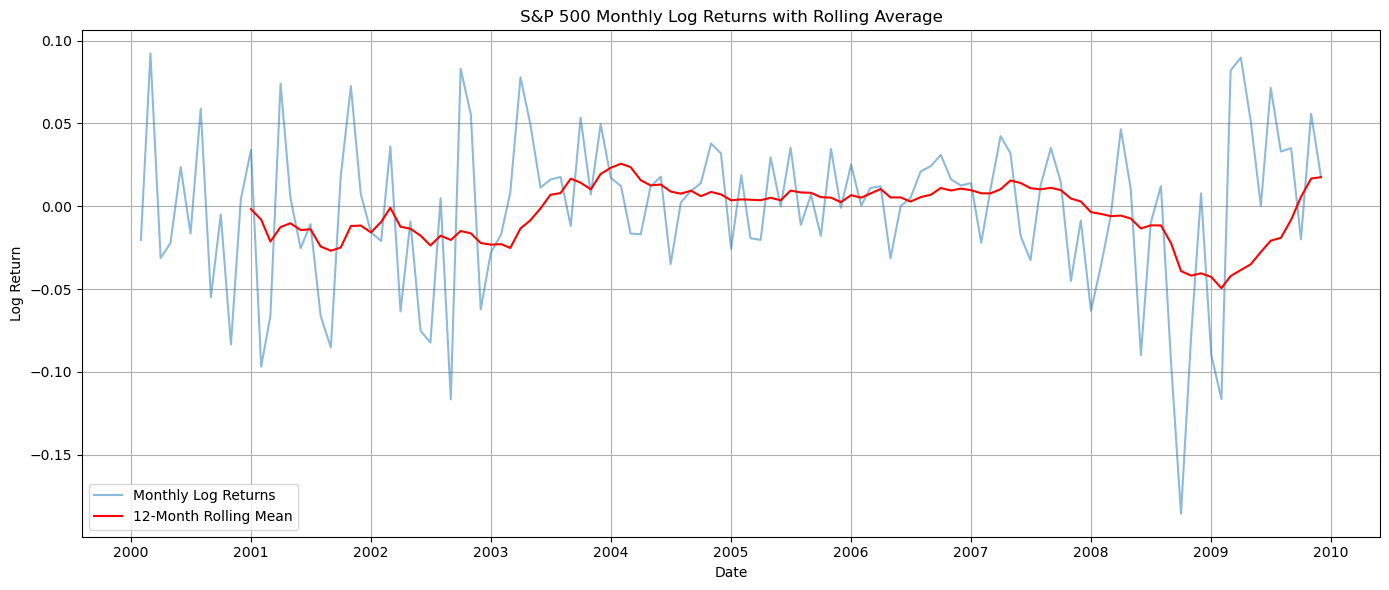

In [7]:
sp500_data['Rolling Mean'] = sp500_data['Log Return'].rolling(window=12).mean() 
#first 11 values are meant to be empty for rolling mean, don't get scared!
plt.figure(figsize=(14, 6))
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Monthly Log Returns', alpha=0.5)
plt.plot(sp500_data.index, sp500_data['Rolling Mean'], label='12-Month Rolling Mean', color='red')
plt.title('S&P 500 Monthly Log Returns with Rolling Average')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

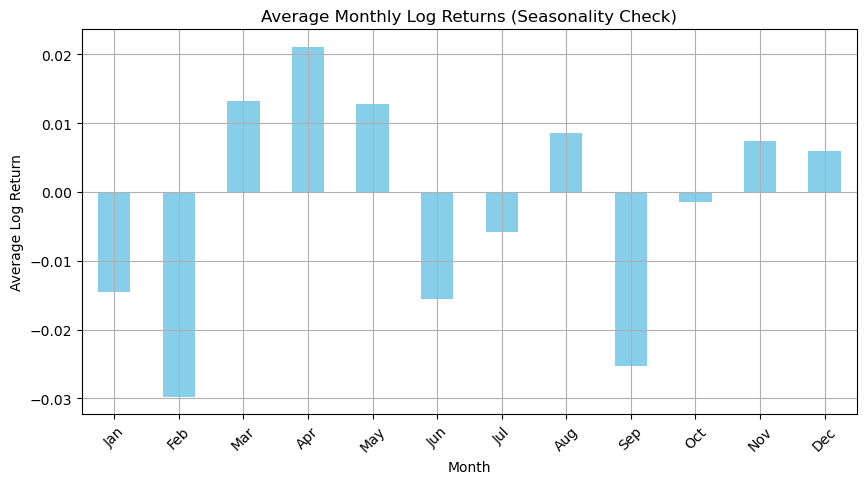

In [8]:
sp500_data['Month'] = sp500_data.index.month
monthly_avg = sp500_data.groupby('Month')['Log Return'].mean()

plt.figure(figsize=(10, 5))
monthly_avg.plot(kind='bar', color='skyblue')
plt.title('Average Monthly Log Returns (Seasonality Check)')
plt.xlabel('Month')
plt.ylabel('Average Log Return')
plt.xticks(ticks=range(0,12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(True)
#plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

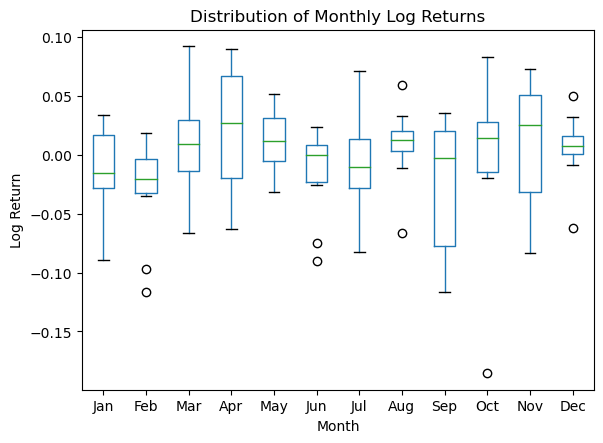

In [9]:
plt.figure(figsize=(12, 6))
sp500_data.boxplot(column='Log Return', by='Month', grid=False)
plt.title('Distribution of Monthly Log Returns')
plt.suptitle('')  # Hide default title
plt.xlabel('Month')
plt.ylabel('Log Return')
plt.xticks(ticks=range(1,13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
#plt.tight_layout()
plt.show()

In [10]:
# Week 2 work 

# ADF test on log returns

adf_result = adfuller(sp500_data['Log Return'])

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -5.075558
p-value: 0.000016
Critical Values:
	1%: -3.4880216384691867
	5%: -2.8867966864160075
	10%: -2.5802408234244947


**Analysis:**

The ADF test statistic of -5.076 and the p-value of 0.000016 both indicate that the null hypothesis of a unit root can be rejected with strong confidence. This supports the conclusion that the log return time series is stationary, meaning it does not exhibit a persistent trend or non-stationary behavior. Since the test statistic is more negative than the 1% critical value (-3.488), we can reject the null hypothesis even at the strictest level of significance. This stationarity property is typical for financial return series and confirms that modeling returns without differencing is appropriate.

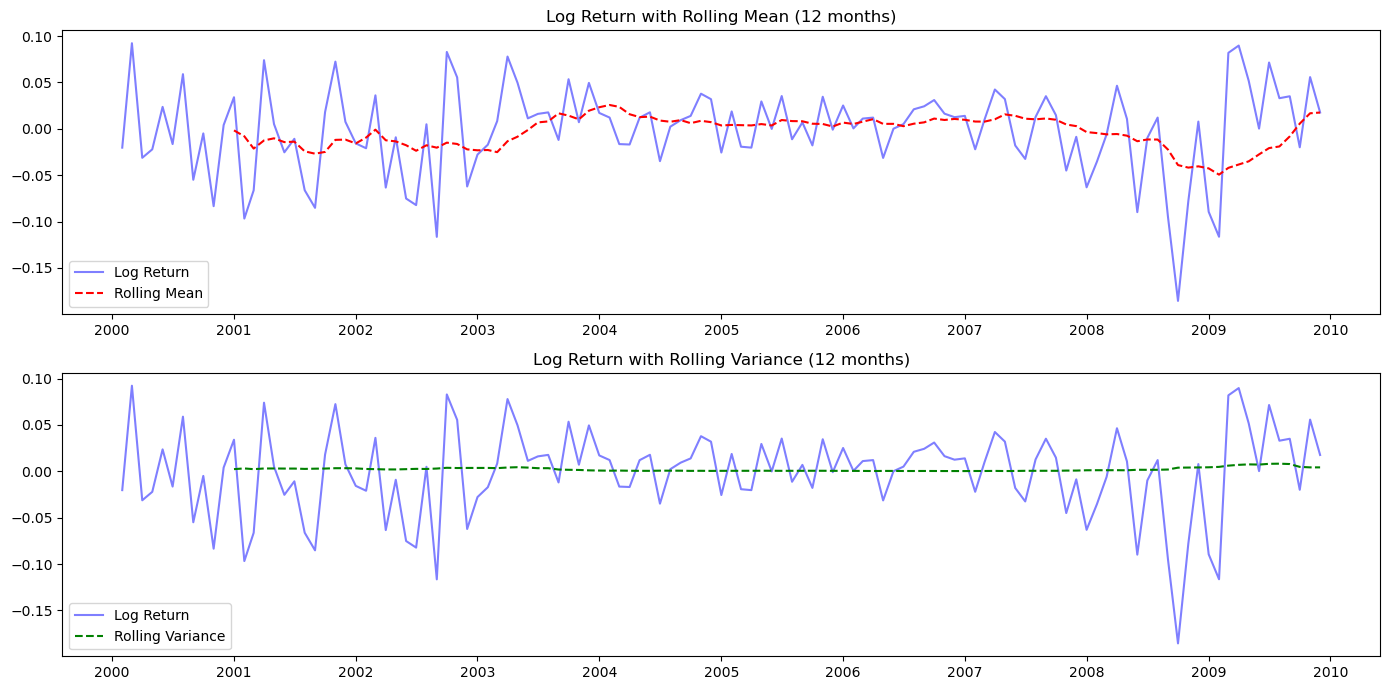

In [11]:
# rolling mean and rolling variance

window = 12

rolling_mean = sp500_data['Log Return'].rolling(window=window).mean()
rolling_variance = sp500_data['Log Return'].rolling(window=window).var()

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue', alpha=0.5)
plt.plot(rolling_mean, label='Rolling Mean', color='red', linestyle='--')
plt.title('Log Return with Rolling Mean (12 months)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue', alpha=0.5)
plt.plot(rolling_variance, label='Rolling Variance', color='green', linestyle='--')
plt.title('Log Return with Rolling Variance (12 months)')
plt.legend()

plt.tight_layout()
plt.show()

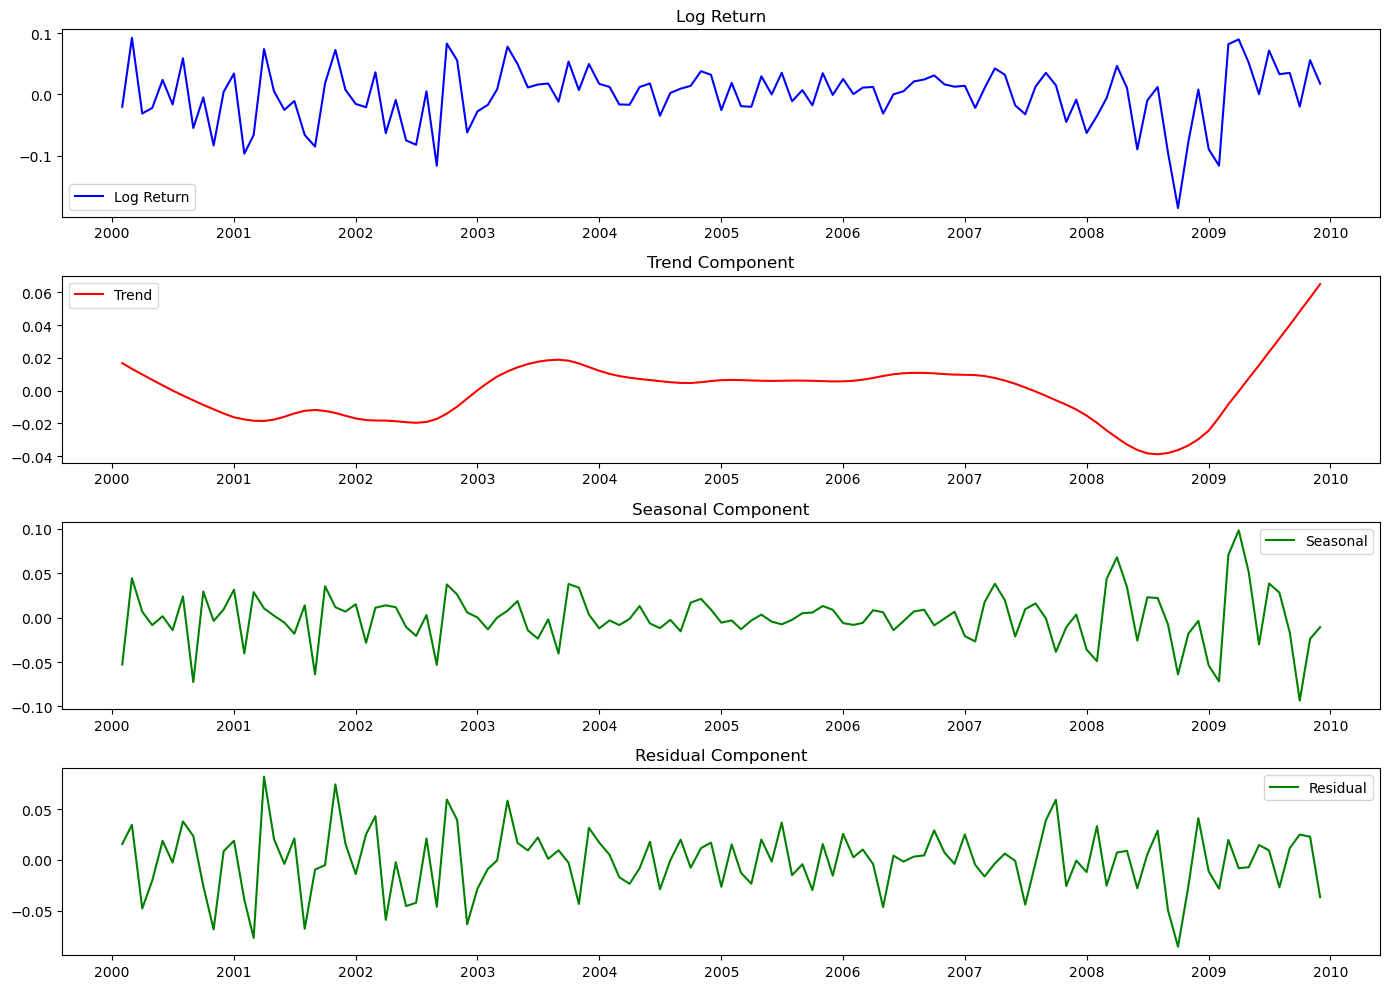

In [12]:
# perform STL decomposition on the log returns

stl = STL(sp500_data['Log Return'], period=12)
result = stl.fit()

seasonal = result.seasonal
trend = result.trend
residual = result.resid

plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue')
plt.title('Log Return')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(sp500_data.index, trend, label='Trend', color='red')
plt.title('Trend Component')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(sp500_data.index, seasonal, label='Seasonal', color='green')
plt.title('Seasonal Component')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(sp500_data.index, residual, label='Residual', color='green')
plt.title('Residual Component')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
arima_model = ARIMA(sp500_data['Log Return'], order=(1, 0, 1))
arima_result = arima_model.fit()
print("ARIMA Model Summary:")
print(arima_result.summary())

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:             Log Return   No. Observations:                  119
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 197.744
Date:                Mon, 28 Apr 2025   AIC                           -387.489
Time:                        09:55:58   BIC                           -376.372
Sample:                    02-01-2000   HQIC                          -382.975
                         - 12-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.005     -0.375      0.708      -0.013       0.009
ar.L1         -0.3941      0.255     -1.544      0.123      -0.894       0.106
ma.L1          0.6090      0.24

**Analysis:**

The ARIMA(1, 0, 1) model results show the following:

Constant (const): The coefficient is -0.0020, but the p-value is 0.708, indicating that it is not statistically significant. This suggests there is no meaningful drift or average return in the series over this period.

AR(1) coefficient: The coefficient is -0.3941, and the p-value is 0.123, meaning it is not statistically significant. This implies that the first lag of the series does not strongly influence the current log return.

MA(1) coefficient: The coefficient is 0.6090, and it is statistically significant (p-value = 0.013). This suggests that the model’s first moving average term captures meaningful patterns from past errors and helps explain some of the short-term movements in returns.

Sigma2: The error variance (σ²) is 0.0021 with a p-value of 0.000, meaning it is highly significant and the model's residual variance is stable and well-estimated.

Ljung-Box (Q) test: The p-value of 0.98 indicates no significant autocorrelation remains in the residuals at lag 1, suggesting the model has effectively captured the major time-dependent patterns.

Jarque-Bera (JB) test: The p-value of 0.00 shows that the residuals are not normally distributed, with mild left skewness (-0.57) and slightly heavy tails (kurtosis = 4.02), typical in financial return data.

Heteroskedasticity (H): The p-value of 0.77 suggests that there is no strong evidence of heteroskedasticity (changing volatility) in the residuals.

In [14]:
sarima_model = SARIMAX(sp500_data['Log Return'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
sarima_result = sarima_model.fit()
print("\nSARIMA Model Summary:")
print(sarima_result.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.65846D+00    |proj g|=  4.96167D-01

At iterate    5    f= -1.65883D+00    |proj g|=  4.56322D-01

At iterate   10    f= -1.66108D+00    |proj g|=  4.94582D-02

At iterate   15    f= -1.66111D+00    |proj g|=  6.65112D-02

At iterate   20    f= -1.66118D+00    |proj g|=  1.44070D-03

At iterate   25    f= -1.66120D+00    |proj g|=  1.90419D-02

At iterate   30    f= -1.66131D+00    |proj g|=  1.21709D-02


 This problem is unconstrained.



At iterate   35    f= -1.66131D+00    |proj g|=  5.86762D-04

At iterate   40    f= -1.66131D+00    |proj g|=  9.37676D-03

At iterate   45    f= -1.66132D+00    |proj g|=  4.44231D-03

At iterate   50    f= -1.66151D+00    |proj g|=  2.55916D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     65      1     0     0   2.559D-01  -1.662D+00
  F =  -1.6615062112128665     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

SARIMA Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                         Log Return   No. Obser

**Analysis:**

The SARIMA(1, 0, 1)(1, 0, 1, 12) model results show the following:

AR(1) coefficient: The coefficient is -0.4224 with a p-value of 0.122, meaning it is not statistically significant. This suggests that the first lag of the series does not strongly impact current returns.

MA(1) coefficient: The coefficient is 0.6272 and is statistically significant (p-value = 0.016), indicating that short-term shocks or past errors meaningfully contribute to explaining current log returns.

Seasonal AR(12) coefficient: The coefficient is 0.2776, but the p-value is 0.918, meaning it is not significant, and there is no strong seasonal autoregressive effect at the 12-month lag.

Seasonal MA(12) coefficient: The coefficient is -0.2233 with a p-value of 0.934, which is also not statistically significant, suggesting no meaningful seasonal moving average behavior.

Sigma2: The error variance (σ²) is 0.0021 with a p-value of 0.000, making it highly significant and confirming that the model estimates residual variability reliably.

Ljung-Box (Q) test: The p-value of 0.86 suggests no significant autocorrelation remains in the residuals, meaning the model has effectively captured the main time dependencies in the data.

Jarque-Bera (JB) test: The p-value of 0.00 indicates the residuals are not normally distributed, with left skewness (-0.57) and slightly heavy tails (kurtosis = 4.02), which is typical for financial time series.

Heteroskedasticity (H): The p-value of 0.77 suggests that there is no strong evidence of heteroskedasticity (changing variance) in the residuals.

Comparing the two models, the ARIMA(1,0,1) slightly outperforms the SARIMA(1,0,1)(1,0,1,12) model in this sample. The ARIMA model has a lower AIC (-387.489 vs. -385.438) and a slightly higher log-likelihood, suggesting a better overall fit. Additionally, while both models capture the residual structure well without significant autocorrelation, the SARIMA model’s seasonal components are not statistically significant, meaning that adding seasonal terms does not improve the model meaningfully. Therefore, the simpler ARIMA model is preferred for modeling log returns during this period.


In [15]:
# Ensure 'Month' column is category
sp500_data['Month'] = sp500_data.index.month.astype('category')

# Create dummy variables (January as baseline)
month_dummies = pd.get_dummies(sp500_data['Month'], drop_first=True)

# Regression setup
X = sm.add_constant(month_dummies)
y = sp500_data['Log Return']

reg_model = sm.OLS(y, X)
reg_result = reg_model.fit()

print("\nRegression Summary (Monthly Dummies):")
print(reg_result.summary())



Regression Summary (Monthly Dummies):
                            OLS Regression Results                            
Dep. Variable:             Log Return   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.198
Date:                Mon, 28 Apr 2025   Prob (F-statistic):              0.298
Time:                        10:00:17   Log-Likelihood:                 201.54
No. Observations:                 119   AIC:                            -379.1
Df Residuals:                     107   BIC:                            -345.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

**Analysis:**

The OLS regression results for monthly dummies show the following key findings:

* Intercept (const): The coefficient is -0.0146 with a p-value of 0.352, meaning it is not statistically significant. This suggests that the average log return for the baseline month (January) is not meaningfully different from zero.

* Other Months: None of the monthly dummy coefficients (February through December) are statistically significant at conventional levels (all p-values > 0.05). This indicates that there are no strong or consistent seasonal patterns in returns across different months during this sample period.

* Model Fit: The R-squared value is 0.110, meaning the model explains about 11% of the variation in log returns, but the overall F-statistic p-value (0.298) suggests the model is not statistically significant as a whole.

* Jarque-Bera test: The p-value is 4.98e-06, indicating that the residuals are not normally distributed, with evidence of left skewness.

* Skew: The skewness value is -0.861, showing the residuals are moderately left-skewed.

* Kurtosis: The kurtosis is 4.399, suggesting the residuals have heavier tails than a normal distribution, a common pattern in financial return series.



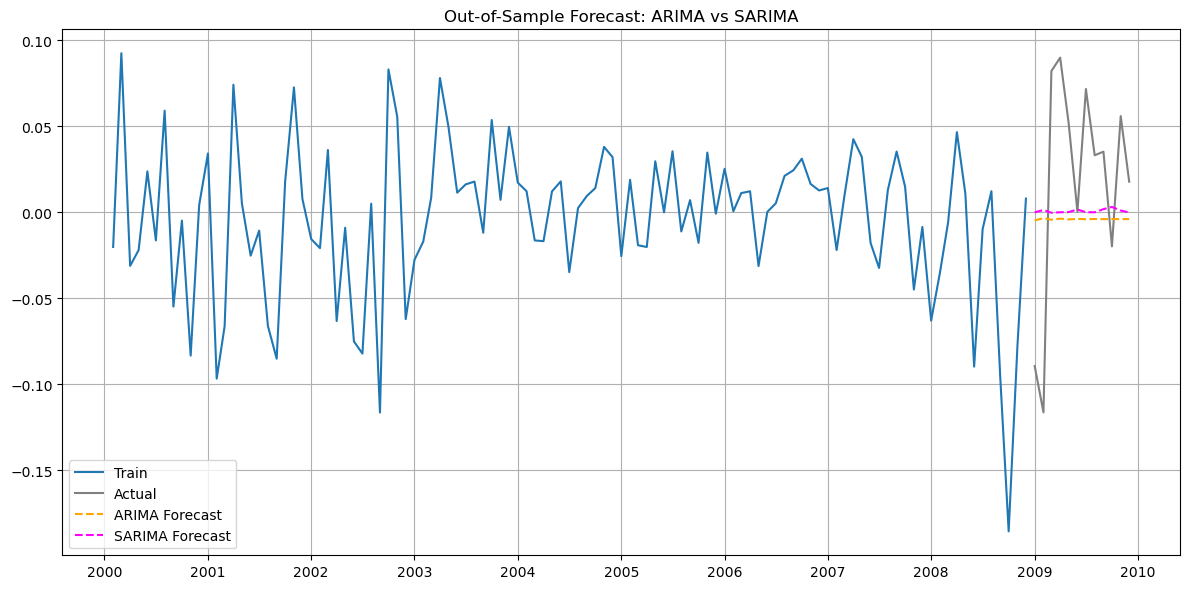

In [16]:
# week 4

# generate out of sample forecasts from ARIMA & SARIMA models

# split the data into testing and training 
train = sp500_data['Log Return'][:-12] 
test = sp500_data['Log Return'][-12:] # last 12 months

# fit ARIMA model w/ training data
arima_model = ARIMA(train, order=(1, 0, 1))
arima_result = arima_model.fit()

# forecast ARIMA
arima_forecast = arima_result.forecast(steps=12)

# fit SARIMA model
sarima_model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
sarima_result = sarima_model.fit(disp=False)

# forecast SARIMA
sarima_forecast = sarima_result.forecast(steps=12)

# plot forecasts
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual', color='grey')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--', color='orange')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', linestyle='--', color='magenta')
plt.title('Out-of-Sample Forecast: ARIMA vs SARIMA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

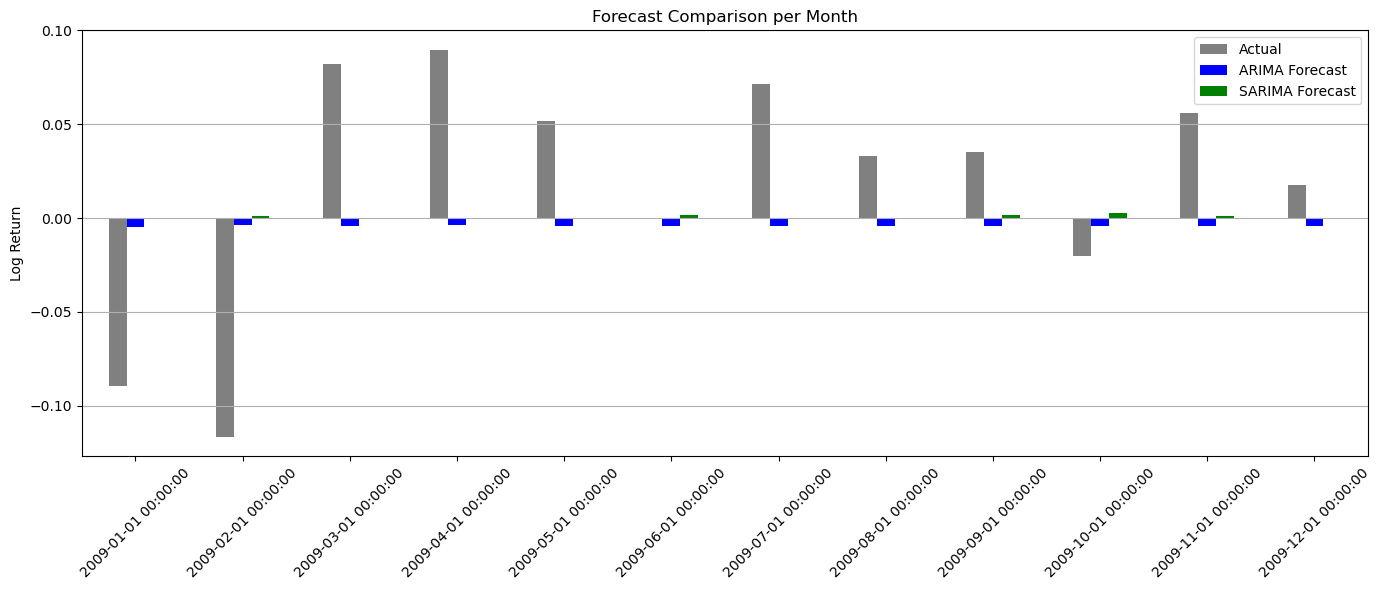

In [17]:
# plot monthly forecast comparisons

df_compare = pd.DataFrame({
    'Actual': test,
    'ARIMA Forecast': arima_forecast,
    'SARIMA Forecast': sarima_forecast
})

df_compare.plot(kind='bar', figsize=(14, 6), color=['grey', 'blue', 'green'])
plt.title('Forecast Comparison per Month')
plt.ylabel('Log Return')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

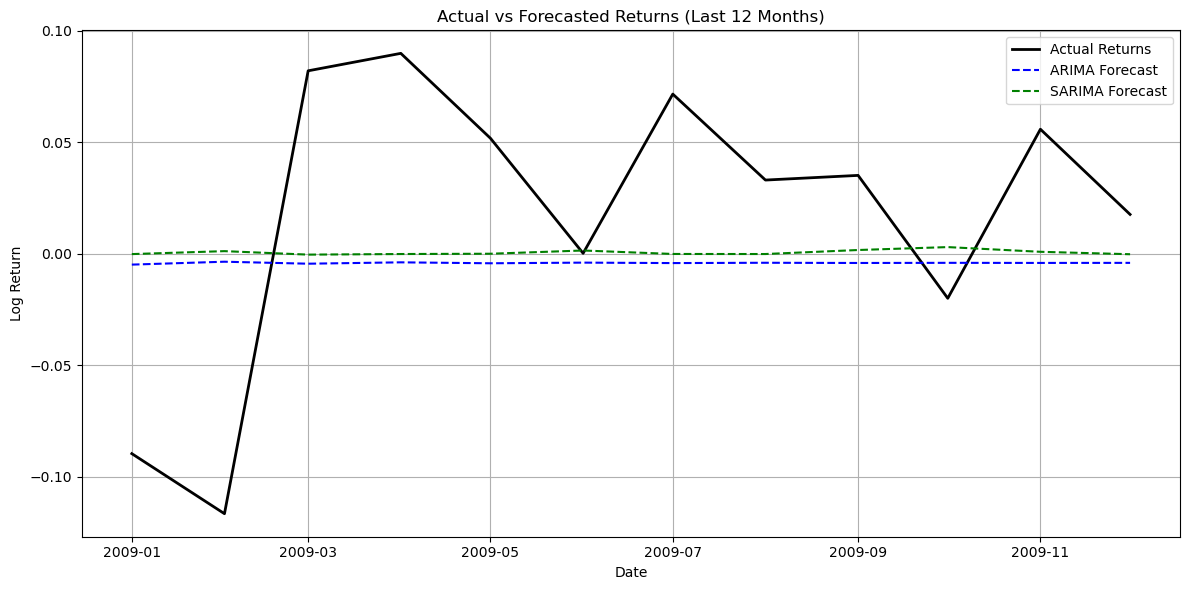

In [18]:
# actuals vs forecasted results plot

plt.figure(figsize=(12, 6))

# actual
plt.plot(test.index, test, label='Actual Returns', color='black', linewidth=2)

# ARIMA forecast
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='blue', linestyle='--')

# SARIMA forecast
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green', linestyle='--')

plt.title('Actual vs Forecasted Returns (Last 12 Months)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# evaluate forcasting accuracy using MAE and RMSE

# ARIMA accuracy
arima_mae = mean_absolute_error(test, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))

# SARIMA accuracy
sarima_mae = mean_absolute_error(test, sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))

print("Forecast Accuracy (last 12 months):")
print(f"ARIMA MAE: {arima_mae:.5f}")
print(f"ARIMA RMSE: {arima_rmse:.5f}")
print()
print(f"SARIMA MAE: {sarima_mae:.5f}")
print(f"SARIMA RMSE: {sarima_rmse:.5f}")

Forecast Accuracy (last 12 months):
ARIMA MAE: 0.05727
ARIMA RMSE: 0.06599

SARIMA MAE: 0.05551
SARIMA RMSE: 0.06492


**Analysis:**


SARIMA slightly outperforms ARIMA in forecast accuracy, with a lower MAE (0.05551) and RMSE (0.06492) compared to ARIMA's MAE (0.05727) and RMSE (0.06599). However, both models show very similar levels of forecasting error overall.



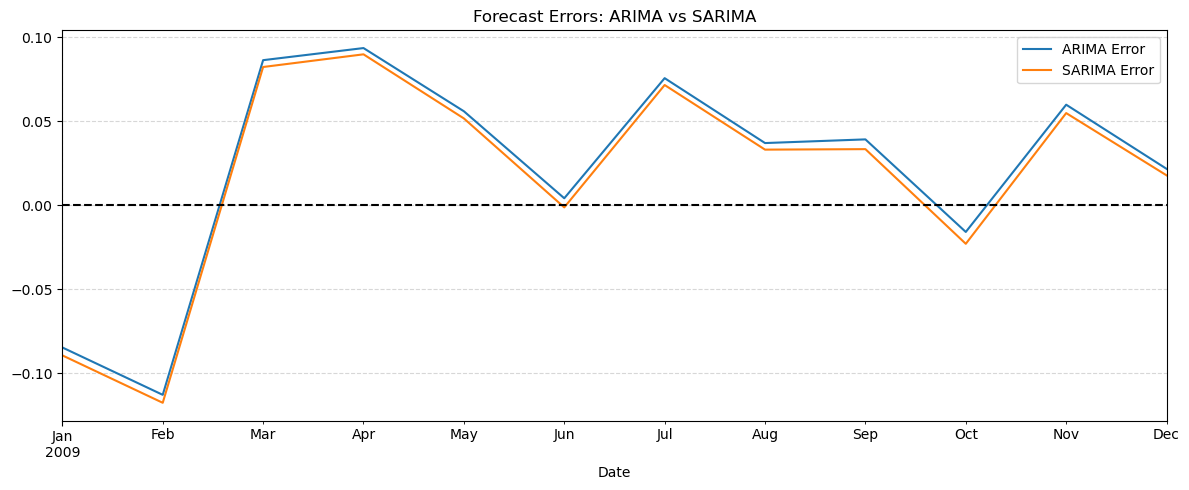

In [20]:
# plot forecast errors for ARIMA & SARIMA

errors = pd.DataFrame({
    'ARIMA Error': test - arima_forecast,
    'SARIMA Error': test - sarima_forecast
})

errors.plot(figsize=(12, 5), title='Forecast Errors: ARIMA vs SARIMA')
plt.axhline(0, color='black', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()